## Clustering Analysis

In this notebook, we show our cluster analysis comparing play styles in Club (NBA + other international) leagues and FIBA. Our approach is to use K-means clustering to cluster players from the three leagues, and then analyze the way players map from cluster to cluster across club play and FIBA play. We use play type distributions parsed from the Synergy data as the features for our clustering. We also list some of our observations and next steps.

## Load Data
We load three sheets with results from parsing the Synergy data for FIBA, NBA and International competitions, and merge the three dataframes. Note that this data is from 2013-2019. We remove any rows with fewer than 50 total plays.

In [1]:
import pandas as pd
import numpy as np
df_FIBA = pd.read_csv("FIBA_Play_Counts.csv", encoding='latin-1')
df_FIBA.rename(columns={"Unnamed: 0": "Player"}, inplace=True)
df_FIBA['Source'] = 'FIBA'
df_FIBA.head()

,Player,P&R Ball Handler,Spot-Up,Transition,ISO,Post-Up,P&R Roll Man,Cut,Offensive Rebound,Off Screen,Hand Off,Total,Source
0,Ricky Rubio,284,121,64,20,0,0,9,25,7,16,546,FIBA
1,Luis Scola,0,122,105,19,304,167,125,97,20,1,960,FIBA
2,Rudy Fernandez,109,103,54,33,0,1,20,37,36,12,405,FIBA
3,Juancho Hernangomez,2,53,25,5,5,8,26,35,13,1,173,FIBA
4,Pierre Oriola,0,21,10,0,3,8,18,38,1,1,100,FIBA


In [2]:
df_INTL = pd.read_csv("INTL_Play_Counts.csv", encoding='latin-1')
df_INTL.rename(columns={"Unnamed: 0": "Player"}, inplace=True)
df_INTL['Source'] = 'INTL'
df_INTL.head()

,Player,P&R Ball Handler,Spot-Up,Transition,ISO,Post-Up,P&R Roll Man,Cut,Offensive Rebound,Off Screen,Hand Off,Total,Source
0,Jerome Randle,2780,417,638,633,0,1,67,99,107,173,4915,INTL
1,Elmedin Kikanovic,9,277,173,29,986,761,519,424,21,5,3204,INTL
2,Rickey Paulding,848,925,382,353,282,12,231,265,378,62,3738,INTL
3,Casper Ware,2059,471,430,637,4,1,48,76,166,185,4077,INTL
4,Daniel Johnson,32,474,373,84,853,348,331,399,43,25,2962,INTL


In [3]:
df_NBA = pd.read_csv('NBA_PLAY_COUNTS.csv', encoding='latin-1')
df_NBA.rename(columns={"Unnamed: 0": "Player"}, inplace=True)
df_NBA['Source'] = 'NBA'
df_NBA.head()

,Player,P&R Ball Handler,Spot-Up,Transition,ISO,Post-Up,P&R Roll Man,Cut,Offensive Rebound,Off Screen,Hand Off,Total,Source
0,Dwyane Wade,4872,818,1207,1149,1232,26,484,437,396,364,10985,NBA
1,Danny Green,751,2193,1168,127,42,21,212,350,512,282,5658,NBA
2,Lebron James,863,199,477,612,514,64,121,92,86,7,3035,NBA
3,Kawhi Leonard,3109,1734,1487,1471,1223,60,310,605,523,463,10985,NBA
4,Tim Duncan,6,280,169,98,1235,757,635,556,52,13,3801,NBA


In [4]:
df = pd.concat([df_NBA, df_INTL, df_FIBA]).reset_index()
s = df['Player'].value_counts()
##df[df['Player'].isin(s[s>=2].index)]
df['Type'] = df['Source'].apply(lambda x: 'FIBA' if x=='FIBA' else 'Club')
df

,index,Player,P&R Ball Handler,Spot-Up,Transition,ISO,Post-Up,P&R Roll Man,Cut,Offensive Rebound,Off Screen,Hand Off,Total,Source,Type
0,0,Dwyane Wade,4872,818,1207,1149,1232,26,484,437,396,364,10985,NBA,Club
1,1,Danny Green,751,2193,1168,127,42,21,212,350,512,282,5658,NBA,Club
2,2,Lebron James,863,199,477,612,514,64,121,92,86,7,3035,NBA,Club
3,3,Kawhi Leonard,3109,1734,1487,1471,1223,60,310,605,523,463,10985,NBA,Club
4,4,Tim Duncan,6,280,169,98,1235,757,635,556,52,13,3801,NBA,Club
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8654,2868,Chin Yong Wong,0,2,1,0,0,0,0,0,0,0,3,FIBA,FIBA
8655,2869,Wee Seng Wong,1,5,0,0,0,0,0,0,0,0,6,FIBA,FIBA
8656,2870,Min Joe Foong,0,0,0,0,0,0,0,0,0,0,0,FIBA,FIBA
8657,2871,Lok Seng Mak,0,1,0,0,0,0,1,0,0,0,2,FIBA,FIBA


Now, we convert the columns from play count totals to proportions, and prepare a dataframe to be passed into the clustering algorithm.

In [5]:
play_types = ['P&R Ball Handler', 'Spot-Up', 'Transition', 'ISO', 'Post-Up', 'P&R Roll Man', 'Cut', 'Offensive Rebound', 'Off Screen', 'Hand Off']
for p in play_types:
    df['% ' + p] = df[p] / df['Total']

In [6]:
df = df[df['Total'] >= 50].sort_values(['Source','Total'], ascending=[True, False])
filt_df = df[['% ' + p for p in play_types]].copy()

filt_df

,% P&R Ball Handler,% Spot-Up,% Transition,% ISO,% Post-Up,% P&R Roll Man,% Cut,% Offensive Rebound,% Off Screen,% Hand Off
5827,0.365904,0.173597,0.099792,0.097713,0.032225,0.001040,0.035343,0.032225,0.090437,0.071726
5787,0.000000,0.127083,0.109375,0.019792,0.316667,0.173958,0.130208,0.101042,0.020833,0.001042
5791,0.620438,0.077164,0.145985,0.072993,0.000000,0.002086,0.009385,0.025026,0.016684,0.030240
5937,0.734694,0.074114,0.062299,0.038668,0.003222,0.000000,0.016112,0.024705,0.020408,0.025779
7407,0.234554,0.136156,0.129291,0.170481,0.141876,0.002288,0.044622,0.025172,0.105263,0.010297
...,...,...,...,...,...,...,...,...,...,...
1300,0.117647,0.313725,0.274510,0.058824,0.000000,0.000000,0.039216,0.098039,0.019608,0.078431
1307,0.039216,0.254902,0.137255,0.039216,0.000000,0.098039,0.176471,0.215686,0.000000,0.039216
385,0.220000,0.160000,0.120000,0.160000,0.100000,0.040000,0.060000,0.080000,0.060000,0.000000
876,0.780000,0.060000,0.080000,0.060000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000


## Clustering

We run K-means clustering for k (the number of clusters) between 5 and 15. We plot the inertia for each k. The inertia (also known as within-cluster sum-of-squares) measures how internally coherent each cluster is, with a lower inertia representing a better clustering model. See https://scikit-learn.org/stable/modules/clustering.html for more details.

In [7]:
from sklearn.cluster import KMeans
inertias = []
for i in range(5, 15):
    test_model = KMeans(n_clusters=i, random_state = 42)
    test_model.fit(filt_df)
    inertias.append(test_model.inertia_)
print(inertias)

[146.25803860551753, 130.3934704306596, 117.17101455780424, 110.91432339336454, 105.95518519490726, 101.73316726224687, 97.83896235584376, 94.39884198483556, 91.31903626876161, 88.32045021212713]


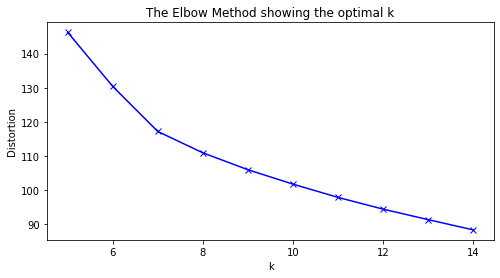

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(range(5,15), inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

From this, we see using the elbow method that the best number of clusters is 7. Therefore, let us run the model with 7 clusters again and analyze its results.

In [9]:
num_clusters = 7
test_model = KMeans(n_clusters=num_clusters, random_state = 42)
test_model.fit(filt_df)
filt_df['Cluster'] = test_model.labels_
filt_df['Cluster'].value_counts()

1    1127
2    1054
6    1041
0     856
4     796
3     732
5     557
Name: Cluster, dtype: int64

In [10]:
cluster_centres = np.transpose(test_model.cluster_centers_)
player_types = ['Stretch bigs', 'Playmakers', 'Ball handlers', 'Driving bigs', 'Spot-up shooters', 'Low-post bigs', 'Off-ball wings']
cluster_centres_df = pd.DataFrame(cluster_centres, play_types, columns = player_types)
cluster_centres_df

,Stretch bigs,Playmakers,Ball handlers,Driving bigs,Spot-up shooters,Low-post bigs,Off-ball wings
P&R Ball Handler,0.019380,0.418885,0.595322,0.002456,0.057339,0.002820,0.216258
Spot-Up,0.259274,0.189124,0.128268,0.073625,0.411532,0.073507,0.275899
Transition,0.105026,0.127861,0.090165,0.070276,0.137146,0.055147,0.160909
ISO,0.051280,0.090424,0.086318,0.017541,0.036357,0.024284,0.067343
Post-Up,0.169426,0.016496,0.005903,0.157157,0.046753,0.357566,0.028361
P&R Roll Man,0.110038,0.001256,0.000380,0.215006,0.041988,0.152968,0.005129
Cut,0.112456,0.027375,0.013242,0.214083,0.077936,0.152379,0.047258
Offensive Rebound,0.137004,0.044969,0.029484,0.243829,0.116450,0.172986,0.069221
Off Screen,0.029171,0.051167,0.023610,0.004004,0.056322,0.006816,0.090218
Hand Off,0.006944,0.032442,0.027307,0.002023,0.018178,0.001527,0.039405


In [11]:
cluster_centres_df.to_csv("cluster")

In [12]:
df['Cluster'] = filt_df['Cluster']

# Analysis

To get a sense of the different clusters, let's print a few players from each cluster. We print the players with the highest total play counts so they are most likely to be players from the NBA that we would recognize. Keep in mind that these stats are from previous NBA seasons, and some players' styles may have changed since then.

In [13]:
for i in range(num_clusters):
    print("Cluster "+ str(i))
    print(list(df['Player'].loc[filt_df[(filt_df['Cluster'] == i) & (df['Source'] == 'NBA')].head(15).index]))
    print()

Cluster 0
['Anthony Davis', 'Carmelo Anthony', 'Paul Millsap', 'Kevin Love', 'Harrison Barnes', 'Thaddeus Young', 'Al Horford', 'Serge Ibaka', 'Draymond Green', 'Brook Lopez', 'Markieff Morris', 'Dirk Nowitzki', 'Julius Randle', 'Ersan Ilyasova', 'Kelly Olynyk']

Cluster 1
['James Harden', 'Russell Westbrook', 'DeMar DeRozan', 'LeBron James', 'Stephen Curry', 'Kevin Durant', 'Bradley Beal', 'Kyle Lowry', 'Paul George', 'Jimmy Butler', 'CJ McCollum', 'Dwyane Wade', 'Kawhi Leonard', 'Andrew Wiggins', 'Eric Bledsoe']

Cluster 2
['Damian Lillard', 'Kemba Walker', 'Chris Paul', 'John Wall', 'Kyrie Irving', 'Jeff Teague', 'Goran Dragic', 'Dennis Schroder', 'Isaiah Thomas', 'Jrue Holiday', 'Reggie Jackson', 'Mike Conley', 'Victor Oladipo', 'Ricky Rubio', 'Tony Parker']

Cluster 3
['Andre Drummond', 'Derrick Favors', 'Steven Adams', 'Marcin Gortat', 'DeAndre Jordan', 'Robin Lopez', 'Tristan Thompson', 'Mason Plumlee', 'Hassan Whiteside', 'Rudy Gobert', 'Clint Capela', 'Gorgui Dieng', 'Myles Tu

We also print out the average play type proportions for each cluster.

In [14]:
filt_df.groupby('Cluster').mean()

,% P&R Ball Handler,% Spot-Up,% Transition,% ISO,% Post-Up,% P&R Roll Man,% Cut,% Offensive Rebound,% Off Screen,% Hand Off
Cluster,,,,,,,,,,
0,0.019403,0.259131,0.105021,0.051340,0.169476,0.110060,0.112502,0.136909,0.029205,0.006952
1,0.419207,0.188883,0.127928,0.090431,0.016494,0.001256,0.027349,0.045000,0.051027,0.032425
2,0.595497,0.128285,0.090012,0.086280,0.005910,0.000381,0.013233,0.029437,0.023631,0.027332
3,0.002456,0.073625,0.070276,0.017541,0.157157,0.215006,0.214083,0.243829,0.004004,0.002023
4,0.057168,0.411540,0.137154,0.036200,0.046842,0.042102,0.078013,0.116625,0.056208,0.018149
5,0.002820,0.073507,0.055147,0.024284,0.357566,0.152968,0.152379,0.172986,0.006816,0.001527
6,0.216384,0.275954,0.160798,0.067466,0.028341,0.005115,0.047195,0.069168,0.090220,0.039359


These results generally make quite a lot of sense. Here are labels we came up with for the clusters, and the key play types for each.

0 - Stretch bigs: Spot-Up, Post-Up, Offensive Rebound  
1 - Playmakers: Isolation, P&R Ball Handler, Spot-Up  
2 - Ball handlers: P&R Ball Handler, Isolation, Spot-Up  
3 - Driving bigs: Offensive Rebound, Cut, P&R Man  
4 - Spot-up Shooters: Spot-Up, Transition, Off Screen  
5 - Low-post bigs: Post-Up, Offensive Rebound, P&R Man  
6 - Off-Ball wings: Off Screen, Spot-Up, Transition


We notice that clusters 0, 3, and 5 contain more traditional big-men, and expect confusuion between these. Meanwhile, clusters 1, 2, and 4 are also similar, so we expect confusion between these.

We create a confusion matrix mapping players' clusters from Club to FIBA, according to the format below:

| Club\FIBA  | 0 | 1 | 2 |
|-----------|---|---|---|
| 0         | 5 | 2 | 0 |
| 1         | 1 | 8 | 3 |
| 2         | 0 | 4 | 6 |

For example, the confusion matrix above shows that 8 players were clustered into cluster 1 for both leagues, while 2 players are clustered in cluster 0 for their Club stats but cluster 1 for their FIBA stats.

In [15]:
from sklearn.metrics import confusion_matrix

s = df['Player'].value_counts()
all_leagues = s[s==3].index

#If players have data for FIBA, NBA, and INTL, we drop their INTL play
df_2 = df.drop(df[(df['Player'].isin(all_leagues))&(df['Source']=='INTL')].index)

s = df_2['Player'].value_counts()
player_names = df_2['Player'].unique()
names_to_keep = []
for player in player_names:
    src = df_2[df_2['Player'] == player]['Type'].nunique()
    if src == 2:
        names_to_keep.append(player)

clust_df = df_2[df_2['Player'].isin(names_to_keep)]

nba_intl_df = clust_df[clust_df['Type'] == 'Club'].sort_values('Player')
fiba_df = clust_df[clust_df['Type'] == 'FIBA'].sort_values('Player')
nba_df = clust_df[clust_df['Source'] == 'NBA'].sort_values('Player')
intl_df = clust_df[clust_df['Source'] == 'INTL'].sort_values('Player')
if False in nba_intl_df['Player'].values == fiba_df['Player'].values:
    print("Some names do not match!")
else:
    print("All names match! Ready to create confusion matrix.")
    
cm = confusion_matrix(nba_intl_df['Cluster'].values, fiba_df['Cluster'].values)
print("{:.2f}% of players stayed in the same cluster.".format(sum(np.diag(cm))/sum(sum(cm)) * 100))
pd.DataFrame(cm)

All names match! Ready to create confusion matrix.
63.93% of players stayed in the same cluster.


,0,1,2,3,4,5,6
0,67,1,0,6,13,7,2
1,0,65,30,0,1,0,22
2,0,33,103,0,0,0,0
3,8,0,0,44,0,22,0
4,14,3,0,0,33,0,17
5,7,0,0,9,1,55,0
6,7,16,4,0,14,0,53


Several observations:
- The number of players who stay in the same cluster is quite reasonable - a fair amount of players switch clusters, but not too many. This suggests that our model is capturing players' styles reasonably well, and that the number of clusters was appropriate.
- As expected, clusters 1 (Playmakers) and 2 (Ball handlers) show a lot of confusion. We also see some confusion between clusters 1 and 6 (Off-Ball wings) and clusters 4 (Spot-up Shooters) and 6. Interestingly, however, clusters 0 (Stretch bigs) and 4 (Spot-up Shooters) also show high confusion. Also, as expected, clusters 3 (Driving bigs) and 5 (Low-post bigs)
- Confusion is in some cases one-sided. That is, for example, many players who were clustered in cluster 3 (Driving bigs) in Club leagues to cluster 5 (Low-post bigs) in FIBA, while far fewer players in cluster 5 in Club leagues moved to cluster 3 in FIBA. This can be attributed to differences in the "global" play styles in FIBA vs. Club leagues. We take a deeper look at this below.

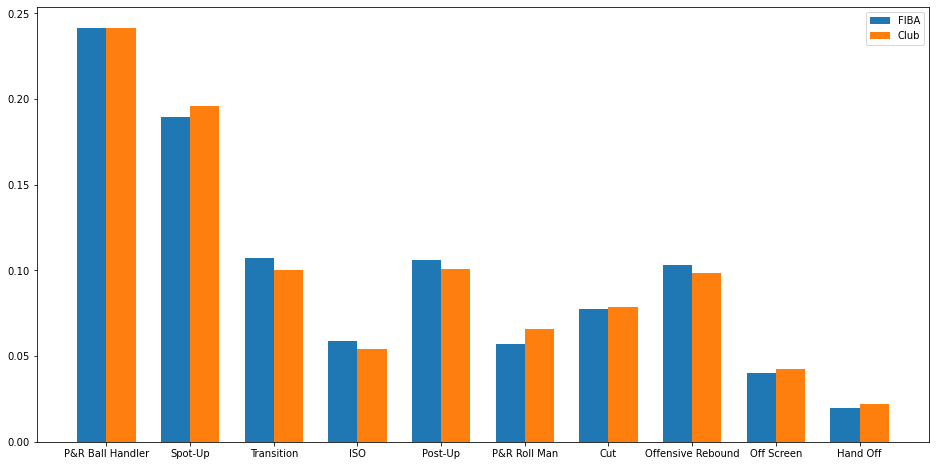

In [16]:
plt.figure(figsize = (16,8))
plt.bar([i for i in range(10)], fiba_df[['% ' + p for p in play_types]].mean(), width = 0.35, label = 'FIBA')
plt.bar([i+0.35 for i in range(10)], nba_intl_df[['% ' + p for p in play_types]].mean(), width = 0.35, label = 'Club')
plt.xticks([i+0.175 for i in range(10)], play_types)
plt.legend()
plt.show()

From this chart, we see that Post-up, Isolation, and Transition plays are more common in FIBA while P&R Roll Man and Spot-Ups were more common in Club Leagues. We can further investigate these trends by looking comparing between FIBA, NBA, and INTL play separately.

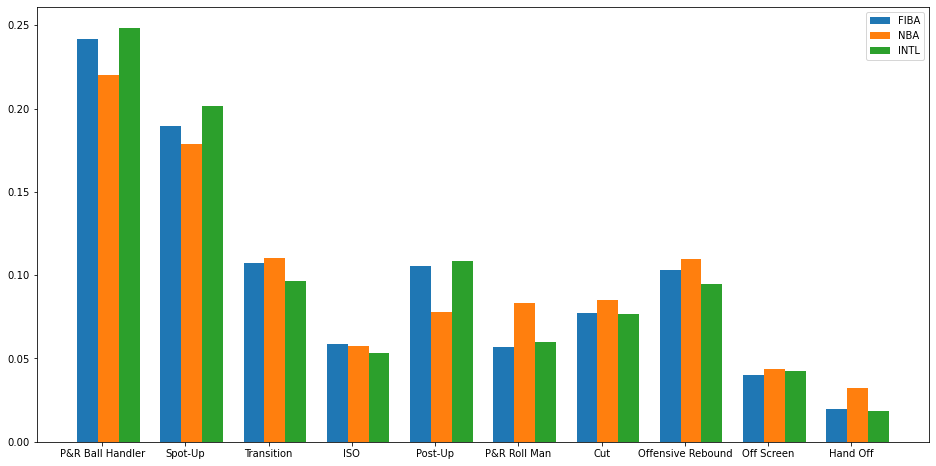

In [17]:
plt.figure(figsize = (16,8))
plt.bar([i for i in range(10)], fiba_df[['% ' + p for p in play_types]].mean(), width = 0.25, label = 'FIBA')
plt.bar([i+0.25 for i in range(10)], nba_df[['% ' + p for p in play_types]].mean(), width = 0.25, label = 'NBA')
plt.bar([i+0.5 for i in range(10)], intl_df[['% ' + p for p in play_types]].mean(), width = 0.25, label = 'INTL')
plt.xticks([i+0.175 for i in range(10)], play_types)
plt.legend()
plt.show()

From this chart, we can make some interesting observations. For example, we see that P&R Ball Handler, Spot-Up and Post-Up plays are far more common in FIBA and INTL leagues compare to the NBA, while Transition, Cut and P&R Roll Man plays are more common in the NBA compared to FIBA and INTl leagues. These observations generally make sense, as P&R Ball Handler, Spot-Up and Post-Up plays represent a more "Global" and more static style of basketball, while Transition, Cut and P&R Roll Man plays represent a more dynamic style of basketball. 

Now, we can also check which players switch clusters between their Club team and FIBA team. For example, we can compare players who move from cluster 1 (Playmakers) in Club play to cluster 6 (Off-Ball Wings) in FIBA play. Below, we see that many of these players are American NBA players who take smaller roles on the USA FIBA team. 

In [18]:
def get_players_by_switch(club_cluster, fiba_cluster):
    out = []
    fiba_set = set(fiba_df[fiba_df['Cluster'] == fiba_cluster]['Player'])
    for p in nba_intl_df[nba_intl_df['Cluster'] == club_cluster]['Player'].values:
        out += [p] if p in fiba_set else []
    return out

print("Players switching from cluster 1 (Club) to 6 (FIBA):")
for p in get_players_by_switch(1, 6):
    print(p)


Players switching from cluster 1 (Club) to 6 (FIBA):
Andrew Rautins
Andrew Wiggins
Brady Heslip
Damjan Stojanovski
Danilo Andjusic
David Jelinek
DeMar DeRozan
Donta Smith
Dragan Milosavljevic
Hristo Zahariev
Jaka Blazic
Jean Salumu
Jimmy Butler
Kevin Durant
Lucio Redivo
Marko Sutalo
Michal Sokolowski
Nemanja Vranjes
Nicolas Batum
Paul George
Stephen Curry
Vitor Benite


Finally, we output our clustering results into a CSV file.

In [19]:
df.index = df['Player']
cols = play_types + ['Cluster']
total_df = pd.DataFrame(index = df.index.unique(), columns = [source +'_' + col for source in ['FIBA', 'INTL', 'NBA'] for col in cols])
for source in ['FIBA', 'INTL', 'NBA']:
    temp_df = df[df['Source']==source]
    for p in temp_df.index.unique():
        total_df.loc[p, [source + '_' + col for col in cols]] = temp_df.loc[p][[col for col in cols]].values
total_df.to_csv("NBA_INTL_FIBA_Clustering.csv")